In [26]:
import csv
import os
import re
import pandas as pd
# Index positions for each element in a row
# level= 0
# pagenum = 1
# block_num = 2
# par_num = 3
# line_num = 4
# word_num = 5
# left = 6
# top = 7
# width = 8
# height = 9
# conf = 10
# text = 11

def sort_csv_by_column(csv_file, sort_column, ascend):
    
    df = pd.read_csv(csv_file)  # Read the CSV file into a DataFrame
    df.sort_values([df.columns[sort_column]], axis=0, ascending=[ascend], inplace=True)  # Sort DataFrame by the chosen column
    
    # Write sorted data back to the CSV file
    df.to_csv(csv_file, index=False)

def load_csv_filenames(csv_dir):
    """Takes a path to a directory with CSVs, then adds all of the paths of
    the CSV files in that directory to the filenames list, which is returned.
    
    Parameters:
        csv_dir - String containing file system location of CSV files.
    Returns:
        filenames - Updated list of CSV file paths.
    """
    filenames = []
    # Scan recursively over all tsv files in a directory
    for folder, subfolders, files in os.walk(csv_dir):
        for file in files:
            if file.endswith('.csv'):
                #Add all the .pdf filenames to a list
                filename = os.path.join(folder, file)
                filenames.append(filename)
                
    return filenames

def left_is_close(list1, list2, dist):
    # Make the list elements numerical so numerical comparisons will be easier
    list1 = list(map(transform_element, list1))
    list2 = list(map(transform_element, list2))
    
    # First determine the leftmost text out of the two, then use that to 
    # check if the words should be joined together.
    if list1[6] < list2[6]:
        return (abs((list1[6] + list1[8]) - list2[6]) <= dist)
    else: 
        return (abs((list2[6] + list2[8]) - list1[6]) <= dist)
    
def top_is_close(line1, line2, dist):
    # Determine if the top coordinates of the two lines are within dist of
    # each other
    return (abs((int(line1[7]) + int(line1[9])) - 
                (int(line2[7]) + int(line2[9]))) <= dist)

def transform_element(item):
    # Attempts to change the item to a float. If that doesn't work then the
    # item is returned as is. If it does work, then it will then either return
    # the float or change the float to an int and return that if possible.
    try:
        num = float(item)
    except (TypeError, ValueError):
        return item
    else:
        if num.is_integer():
            return int(num)
        else:
            return num


def combine_lines(list1, list2):
    # First convert all of the numerical strings in the list to either ints
    # or floats, and leave the text as a string.
#     list1 = list(map(transform_element, list1))
#     list2 = list(map(transform_element, list2))

    # Calculate the new coordinate information for combined text
    left = min(list1[6], list2[6])
    top = min(list1[7], list2[7])
    height = max(list1[9], list2[9])
    conf = ((list1[10] / 100) * (list2[10]/ 100)) * 100
    
    # Ensure that the lists can be passed to this function in any order
    if left == list1[6]:
        width = abs((list2[6] + list2[8]) - list1[6])
        text = f'{list1[11]} {list2[11]}'
    else:
        width = abs((list1[6] + list1[8]) - list2[6])
        text = f'{list2[11]} {list1[11]}'

    # Change the elements of the new list to all strings again, and return
    combined_list = list1[:6].copy()
    combined_list.extend([left, top, width, height, conf, text])
#     combined_list = list(map(str, combined_list))
    return combined_list
    
def clean_dataframe(df):
    # Remove all text entries that are set as 'Nan'
    tmp_df = df.dropna(subset=['text'])
    # Filter out the rows of every text entry that contains spaces and/or '|'
    filtered = tmp_df[tmp_df.text.str.fullmatch('\ *\|?')].index
    # Drop the rows that were just filtered out
    filtered_df = tmp_df.drop(filtered)
    mask = (filtered_df.width * filtered_df.height) < 100
    new_df = filtered_df[~mask]
    return new_df

def realign_text(orig_df, left_dist_def, top_dist_def):
    # Clean the dataframe
    df = clean_dataframe(orig_df)
    # Convert the dataframe to a list
    ref_list = df.values.tolist()
    realigned = ref_list.copy()
    # Keep track of whether or not any changes were made in the latest 
    # iteration. Initialize to True so the while-loop will start.
    modified = True
    # Continue realigning the text until no changes are made
    while modified:
        # Reset to false for beginning of loop
        modified = False
        # Compare every row to every other row only once. Do not compare a row 
        # to itself
        for index, item1 in enumerate(ref_list):
            for item2 in ref_list[index+1:]:
                # Searching for special entires
                if re.search('Mesaverde', item1[11]):
                    left_dist = left_dist_def + 60
                elif re.search('Hilliard', item1[11]):
                    left_dist = left_dist_def + 80
                elif re.search('Carlile', item1[11]):
                    left_dist = left_dist_def+90
                elif re.search('Frontier', item1[11]):
                    left_dist = left_dist_def+90
                elif re.search('WELL.CLASS:?', item1[11]):
                    left_dist = left_dist_def + 60
                elif re.search('(WELL|Well).?(#|No)?:?\ ?.*', item1[11]):
                    left_dist = left_dist_def + 80
                elif re.search('(OPR|OPERATOR|Operator|Opr|opr)\ ?:?', item1[11]):
                    left_dist = left_dist_def + 100
                elif re.search('Loc\'n:?', item1[11], re.IGNORECASE):
                    left_dist = left_dist_def + 100
                else:
                    left_dist = left_dist_def

                top_dist = top_dist_def
                # Check if the two rows being compared are 'close'
                if top_is_close(item1, item2, top_dist) and left_is_close(item1, item2, left_dist):
                    # The realigned list is going to become shorter, so we need to
                    # ensure that the item we are comparing is still in the
                    # realigned list.
                    try:
                        modified = True # Changes have been made
                        # Get the positions of the two lines of text that will be
                        # combined
                        first_pos = realigned.index(item1)
                        second_pos = realigned.index(item2)
                    except ValueError:
                        # At least one of the lines were removed
                        continue

                    # Ensure that we combine the text in the right order
                    if int(item1[6]) < int(item2[6]):
                        realigned[first_pos] = combine_lines(item1, item2)
                        realigned.pop(second_pos)
                    else:
                        realigned[second_pos] = combine_lines(item1, item2)
                        realigned.pop(first_pos)
        ref_list = realigned.copy()
                
    return pd.DataFrame(data=realigned, columns=[
        'level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num',
        'left', 'top', 'width', 'height', 'conf', 'text'
        ])
        
def parse_lines(df, parsed):
    for line in df.itertuples(index=False):
        text = line[11]
        # Well Name / Number
        if re.search('(^WELL|\ WELL).?(#|No)?:?\ ?.*', text, re.IGNORECASE) and line[7] < 250:
            if not re.search('(Wells.*|.*Ask\ Us.*|CLASS.*|ELEV\ ?CHGD.*|Rocky.Mount|WELL\ ID|NUMBER\ ADDED|REPLACE)', text, re.IGNORECASE):
#                 text = re.sub('[=~!@#$%^&*\(\)\[\]\{\}\\\/;]', '', text) # remove any symbols
                parsed['WellName'] += re.search('(^WELL|\ WELL).?(#|No)?[:;]?\ ?.*', text, re.IGNORECASE).group(0)
                
#         # Location
#         if re.search('[0-9]{1,2}-[0-9]{1,2}[A-Z]-[0-9]{1,2}[A-Z]', text):
#             parsed['Location'] = re.search('[0-9]{1,2}-[0-9]{1,2}[A-Z]-[0-9]{1,2}[A-Z]', text).group(0)
            
        # Township and range
#             if re.search('TWP\.?\ ?[0-9A-Z]{1,2}N\-[0-9A-Z]{1,3}W?', text, re.IGNORECASE):
#                 uncut = re.split('TWP\.?\ ?', text, re.IGNORECASE)[-1]
#                 parsed['Township'] = re.split('-[0-9A-Z]{1,3}W?', uncut, re.IGNORECASE)[0]
#                 parsed['Range'] = re.split('[0-9A-Z]{1,2}N\-', uncut, re.IGNORECASE)[-1]

        # Extract the township location of the well
        township = re.search('TWP\ ?\.?\ ?[0-9]+[A-Z]?', text,  re.IGNORECASE)
        if township and line[7] < 150:
            parsed["Township"] =  township.group(0)
            
        # Extract the range location of the well
        Range = re.search('RGE\ ?\.?\ ?[0-9O]+[A-Z]?', text,  re.IGNORECASE)
        if Range and line[7] < 150:
            parsed["Range"] = Range.group(0)
            
        # Section
        if re.search('(Section|Sec)\.?\ ?[0-9]{1,2}', text, re.IGNORECASE):
            if parsed['Section'] == '':
                parsed['Section'] = re.split('(Section|sec)\.?\ ?', text, re.IGNORECASE)[-1]
                
        # township/range/section
        location_match = re.search(r'(\d{1,2})-([\d]{1,2}[A-Z])-(\d{1,3}[A-Z])', text, re.IGNORECASE)
        if location_match:
            if not parsed.get('Township'):
                    parsed['Township'] = location_match.group(2)
            if not parsed.get('Range'):
                    parsed['Range'] = location_match.group(3)
            if not parsed.get('Section'):
                    parsed['Section'] = location_match.group(1)

            parsed['Location'] = location_match.group(0)
            
        # another way to get township/range/section
        location_match2 = re.search('([\d]{1,2}[A-Z])-(\d{1,3}[A-Z])\ (\d{1,2})', text, re.IGNORECASE)
        if location_match2:

            if not parsed.get('Township'):
                    parsed['Township'] = re.search('([\d]{1,2}[A-Z])', text, re.IGNORECASE).group(0)
            if not parsed.get('Range'):
                    parsed['Range'] = re.search('-(\d{1,3}[A-Z])', text, re.IGNORECASE).group(0).replace('-', '')
            if not parsed.get('Section'):
                    parsed['Section'] = re.search('\ (\d{1,2})', text, re.IGNORECASE).group(0)

            parsed['Location'] = location_match2.group(0)
            
        # Yet another way to get Township/range
        location_match3 = re.search('TWP\ ?\d+[A-Z]?-\d+[A-Z]?', text, re.IGNORECASE)
        if location_match3:
            if not parsed.get('Township'):
                parsed['Township'] = re.search('TWP\ ?\d+[A-Z]?', text, re.IGNORECASE).group(0)
            if not parsed.get('Range'):
                parsed['Range'] = re.search('-\d+[A-Z]?', text, re.IGNORECASE).group(0).replace('-', '')
        
        # For cards with "loc'n" section
        location_match4 = re.search('(Loc\'n|LOCATION\ DESCRIPTION):?', text, re.IGNORECASE)
        if location_match4:
            parsed['Location'] += text
        
                
        # Quarter-Quarter info
        if re.search('(c|c\/2)?\ ?(((n|e|s|w)\/2)|(ne|nw|se|sw)\ ?){2,3}.*', text, re.IGNORECASE):
             parsed['QtrQtr'] = re.search('(c|c\/2)?\ ?(((n|e|s|w)\/2)|(ne|nw|se|sw)\ ?){2,3}', text, re.IGNORECASE).group(0)
            

        footage = re.search('(\(?[0-9]{1,4}\ ?(n\/s|f[sn]l|s\/n))\ ?([0-9]{1,4}\ ?(e\/w|f[we]l|w\/e)\)?)', text, re.IGNORECASE)
        if footage:
            parsed['NSFootage'] = footage.group(1)
            parsed['EWFootage'] = footage.group(3)
    
        # Operator
        if re.search('(OPR|OPERATOR):?\ ?.*', text, re.IGNORECASE):
            if parsed['Operator'] == '':
                if re.search("WELL", text, re.IGNORECASE):
                    oprtxt = re.split('WELL', text, re.IGNORECASE)[0]
                else:
                    oprtxt = text
                parsed['Operator'] = re.split('(OPR|OPERATOR):?\ ?', oprtxt, re.IGNORECASE)[-1]
                
        
        # Spud and comp dates
        spud = re.search('(SPUD|COMM|COMMENCED):?\ ?[0-9]{1,2}(\/|-)[0-9]{1,2}(\/|-)[0-9]{2,4}', text, re.IGNORECASE)
        if spud:
            parsed['SpudDate'] = spud.group(0)

        # Completion Date Backup
        comp = re.search('(COMP|COMPL|COMPLETED):?\ ?[0-9]{1,2}(\/|-)[0-9]{1,2}(\/|-)[0-9]{2,4}', text, re.IGNORECASE)
        if comp:
                parsed['CompDate'] = comp.group(0)
                
        # Backup
        if not spud or not comp:
            dates = re.findall(r'\b(\d{1,2}/\d{1,2}/\d{4})\b', text)
            if len(dates) >= 2:
                parsed['SpudDate'] = re.search(r'\b(\d{1,2}[\/-]\d{1,2}[\/-]\d{4})\b', dates[0]).group(0)
                parsed['CompDate'] = re.search(r'\b(\d{1,2}[\/-]\d{1,2}[\/-]\d{4})\b', dates[1]).group(0)   
            
        
#         # Spud & Comp Dates
#         dates = re.findall(r'\b(\d{1,2}/\d{1,2}/\d{4})\b', text)
#         if len(dates) >= 2:
#             parsed['SpudDate'] = dates[0]
#             parsed['CompDate'] = dates[1]
            
        # Elevation
        elevation = re.search('(ELEV|El)\ ?:?\ ?[0-9]+.*', text, re.IGNORECASE)
        if elevation:
            parsed['Elevation'] = elevation.group(0)
            
        # API number
        api = re.search('(API|IDN)?:?\ ?49[-\ ]{0,2}[0-9]{3}[-\ ]{0,2}[0-9]{5}', text, re.IGNORECASE)
        if api:
            parsed['APINum'] = api.group(0)
            
        # Total Depth
        TD = re.search('(TD:?\ ?[0-9]+|[0-9]+\ ?TD)', text)
        if TD and not re.search('PBTD', TD.group(0), re.IGNORECASE):
            parsed['TotalDepth'] = TD.group(0)
            
        # Plug Back
        PB = re.search('(PB|PBTD):?\ ?[0-9]+', text, re.IGNORECASE)
        if PB:
            parsed['PlugBackDepth'] = PB.group(0)
        
        # Initial Production
        if re.search('(init[\ .]*?prod:?[\ .]*|initial[\ .]*production:?\ ?|ip:)\ ?.*',text, re.IGNORECASE):
            if re.search('(prod\ ?zone|production\ ?zone|prod):?\ ?.*',text, re.IGNORECASE):
                parsed['InitProd'] += text + ' '
            
        # Production Zone
        if re.search('(prod[\ .]*?zone|production[\ .]*?zone|prod):?\ ?.*',text, re.IGNORECASE):
            if not re.search('(init[\ .]*?prod:?\ ?|initial[\ .]*?production:?\ ?|ip:)\ ?.*',text, re.IGNORECASE):
                parsed['ProdZone'] += text + ' '
            
        # Card Number
        if re.search('(wy|w)?[0-9]{2}-[0-9]{6}',text, re.IGNORECASE):
            if not re.search('.*Replaces.*', text, re.IGNORECASE):
                parsed['CardNumber'] = text
        
        # Well Status/Class
        well_class = re.search('(class|status):?\ ?.*', text, re.IGNORECASE)
        if well_class:
            parsed['WellStatus'] += " " + well_class.group(0)
        
        # Reissued information
        if re.search('(RE.*ISSUE|Replace|RE.ENTRY)', text, re.IGNORECASE):
            parsed['Reissued'] += ' ' + text
        
        DSTS = re.search('(N[o0]\ (C[0o]re|test|dst)|N[0O]\ C[O0]RES\ [O0]R\ DSTS).*', text, re.IGNORECASE)
        if DSTS:
            parsed['DSTS_Cores'] += " " + DSTS.group(0)
            
        if re.search('(CSG|CASING):?\ ?', text, re.IGNORECASE):
            parsed['Casing'] = text
            
        if re.search("(TOPS|LOG):?", text, re.IGNORECASE):
            parsed['TDFormation'] += text
    return parsed

    
def setLocation(parsed):
        if len(parsed['Location']) > 0:
            parsed['Location'] = ', ' + parsed['Location']
        # Set township, range and section
        if parsed['Section']:
            parsed['Location'] = ' ' + parsed['Section'] + parsed['Location']
        if parsed['Range']:
            parsed['Location'] = ' ' + parsed['Range'] + parsed['Location']
        if parsed['Township']:
            parsed['Location'] = parsed['Township'] + parsed['Location']
        if parsed['QtrQtr']:
            parsed['Location'] = parsed['Location'] + ' QtrQtr: ' + parsed['QtrQtr']
            
        # Remove any double spaces
        parsed['Location'] = re.sub('  ', ' ', parsed['Location'])
        
        return parsed

def setLocationFootage(parsed):
        if parsed['NSFootage']:
            parsed['LocationFootage'] += parsed['NSFootage']
        if parsed['EWFootage']:
            parsed['LocationFootage'] += ' ' + parsed['EWFootage']
        
        return parsed
            
def inside_DST_block(line, left, right, top, bottom):
    if line[6] < left or line[6] > right or line[7] < top or line[7] > bottom:
        return False
    else:
        return True
    
def main():
    # Parse input and output directory options
    argParser = argparse.ArgumentParser()
    argParser.add_argument("-i", "--input", required=True,
                        help="Path to directory containing TSV files")
    argParser.add_argument("-o", "--output", required=True,
                        help="File path that CSV will be outputted to")
    args = vars(argParser.parse_args())
    
    # Make sure that the output is a .csv file
    if args["output"][-4:] != '.csv':
        print("ERROR: Output file must be .csv!", file=sys.stderr)
        return

    # Create the .csv file
    output_csv = pd.DataFrame(columns=['DocumentID','APINum','WellName',
        'Operator','Location','Township','Range','Section','NSFootage','EWFootage','QtrQtr',
        'LocationFootage','Elevation','SpudDate','CompDate','TDFormation','TotalDepth',
        'PlugBackDepth','Casing','InitProd','ProdZone','CardNumber','WellStatus','Reissued',
        'DSTS_Cores'])
    
    filenames = load_csv_filenames(args["input"])
    
    exception_count = 0
    print("Exceptions:")
    for index, file in enumerate(filenames):
        # Define the output row for this specific card
        CardDetails = {'DocumentID':os.path.basename(file),\
        'APINum':'','WellName':'','Operator':'','Location':'',\
        'Township':'','Range':'','Section':'','NSFootage':'',\
        'EWFootage':'','QtrQtr':'','LocationFootage':'','Elevation':'',\
        'SpudDate':'','CompDate':'','TDFormation':'','TotalDepth':'',\
        'PlugBackDepth':'','Casing':'','InitProd':'','ProdZone':'',\
        'CardNumber':'','WellStatus':'','Reissued':'','DSTS_Cores':''}
        
         # Check that we are working on the correct files
        if not file.endswith('.csv'):
            continue
            
        # Read in the CSV file
        try:
            csvfile = pd.read_csv(file, on_bad_lines='skip')
        except Exception as e:
            print(f"File number: {index}, Exception: {e}, file: {file}")
            exception_count +=1
            continue
            
        # Change the text column in the csv to be all strings.
        csvfile.dropna()
        csvfile['text'] = csvfile['text'].apply(str)
        
        #Code to remove all the "nan"s that show up in the output
        mask = csvfile['text'] == 'nan'
        csvfile = csvfile[~mask]
        
        # Clean the text
        csvfile['text'] = csvfile['text'].replace('[,.\\?<>{}"`!@#$%^*+=\[\]]', "", regex=True)
        csvfile['text'] = csvfile['text'].replace("'", "", regex=True)
        csvfile['text'] = csvfile['text'].replace(";", ":", regex=True)
        csvfile['text'] = csvfile['text'].replace("~", "-", regex=True)
        
        # Realign the text
        realigned = realign_text(csvfile, left_dist_def=40, top_dist_def=20)
        
        # Remove random spaces followed by periods
        realigned['text'] = realigned['text'].replace('\ \.', '.', regex=True)
        # Find any matching text lines
        parsed = parse_lines(realigned, CardDetails)
        
        # Set location information
        parsed = setLocation(parsed)
        parsed = setLocationFootage(parsed)
        
        
        
        # Append parsed card information to spreadsheet
        df_parsed = pd.DataFrame([parsed])
        output_csv = pd.concat([output_csv, df_parsed], ignore_index=True)
        
    # Once all files have been parsed, sort the csv file by the card names
    output_csv.to_csv(args["output"], index=False)
    sort_csv_by_column(args["output"], 0, True)
    print("Done parsing cards")
    print(f"Number of exceptions thrown while parsing: {exception_count}")
    return
    
# if __name__ =='__main__':
#     main()

left: 75, width: 172, top: 86, height: 16, text: STATE: WYOMING
left: 790, width: 136, top: 85, height: 16, text: 26N-112W 8
left: 75, width: 181, top: 106, height: 17, text: COUNTY: LINCOLN
left: 790, width: 54, top: 108, height: 14, text: SE NE
left: 70, width: 226, top: 121, height: 32, text: API 49-023-20723 EAST
left: 791, width: 162, top: 130, height: 13, text: 1678 FNL 925 FEL
left: 75, width: 165, top: 148, height: 17, text: FIELD: LABARGE
left: 790, width: 131, top: 148, height: 17, text: STATUS GAS
left: 75, width: 178, top: 170, height: 16, text: WELL CLASS: DG
left: 75, width: 172, top: 191, height: 16, text: OPR: ENRON O&G
left: 446, width: 294, top: 190, height: 17, text: 64-8D EAST LAGARGE UNIT
left: 71, width: 668, top: 247, height: 53, text: pur- 7966 (07/30/94) FM/TD: FRONTIER PBTD: 7850 MD 7966BHT: 150F
left: 148, width: 469, top: 255, height: 17, text: 07/21/94 COMP: 11/04/94 ELEV: 6967 KB 6954 GR
left: 75, width: 387, top: 297, height: 21, text: CONTR: NOT RPTD (R)

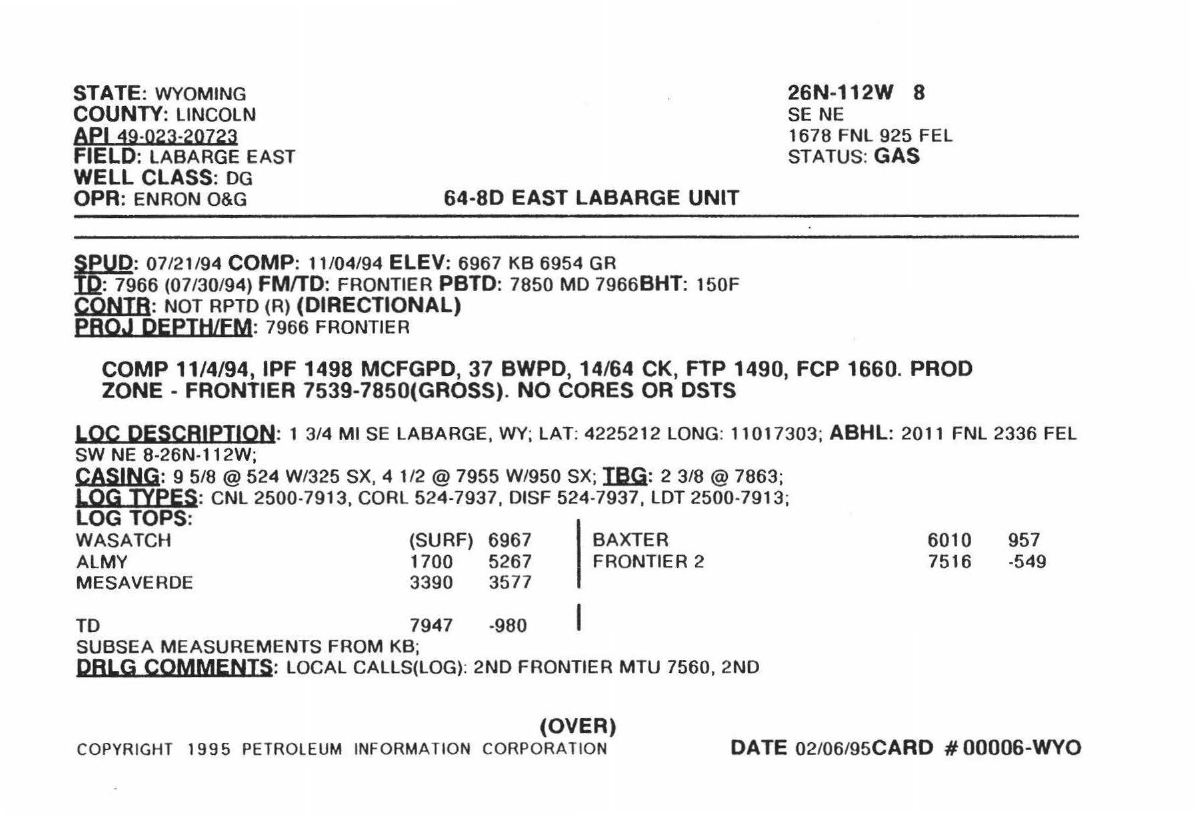

In [31]:
########################################################################3
# boundingBox = True
boundingBox = False
########################################################################
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from pdf2image import convert_from_path
import pandas as pd
import os
import re
pd.set_option('expand_frame_repr', False)
box = 'Box2/'
imgDir = '/pfs/tc1/project/arcc-students/OilWellProject2023.Summer/non_blank_pages/' + box
imgFile = '199-0120.pdf_page_1.pdf'
poppler = '/pfs/tc1/project/arcc-students/csloan5/environments/GPU_env/bin/' 
image = convert_from_path(imgDir+imgFile, poppler_path=poppler)[0]


csv_dir = '/pfs/tc1/project/arcc-students/OilWellProject2023.Summer/ConvertedCSVFiles/' + box
csv_filename = imgFile + '.csv'

# Read in the TSV file
try:
    csvfile = pd.read_csv(csv_dir + csv_filename, on_bad_lines='skip')
except Exception as e:
    print(e, csv_filename)

csvfile['text'] = csvfile['text'].apply(str)
mask = csvfile['text'] == 'nan'
csvfile = csvfile[~mask]

# Clean the text
csvfile['text'] = csvfile['text'].replace('[,\\?<>{}"`!@#$%^*+=\[\]]', "", regex=True)
csvfile['text'] = csvfile['text'].replace('\_', ' ', regex=True)
csvfile['text'] = csvfile['text'].replace("'", "", regex=True)
csvfile['text'] = csvfile['text'].replace(";", ":", regex=True)
csvfile['text'] = csvfile['text'].replace("~", "-", regex=True)
        
# for line in csvfile.itertuples(index=False):
#     print (f"left: {line[6]}, width: {line[8]}, top: {line[7]}, height: {line[9]}, text: {line[11]}\t\t\t{line[6]}, {line[7]}, {line[8]}, {line[9]}")


realigned = realign_text(csvfile, left_dist_def=80, top_dist_def=20)
for line in realigned.itertuples(index=False):
    print (f"left: {line[6]}, width: {line[8]}, top: {line[7]}, height: {line[9]}, text: {line[11]}")


CardDetails = {'DocumentID':csv_filename,'CardTypeID':'1','OCRStatus':'Done',\
    'APINum':'','WellName':'','Operator':'','Location':'',\
    'Township':'','Range':'','Section':'','NSFootage':'',\
    'EWFootage':'','QtrQtr':'','LocationFootage':'','Elevation':'',\
    'SpudDate':'','CompDate':'','TDFormation':'','TotalDepth':'',\
    'PlugBackDepth':'','Casing':'','InitProd':'','ProdZone':'',\
    'CardNumber':'','WellStatus':'','Reissued':'','DSTS_Cores':''}

parsed = parse_lines(realigned, CardDetails)

if not parsed.get('Location'):
    parsed = setLocation(parsed)
elif parsed['QtrQtr']:
    parsed['Location'] = parsed['Location'] + ' QtrQtr: ' + parsed['QtrQtr']
    
parsed = setLocationFootage(parsed)


print(f"API: {parsed['APINum']}\nName: {parsed['WellName']}\nOPR: {parsed['Operator']}\nLocation: {parsed['Location']}")
print(f"Township: {parsed['Township']}\nRange: {parsed['Range']}\nSection: {parsed['Section']}")
print(f"NS: {parsed['NSFootage']}\nEW: {parsed['EWFootage']}\nQtrQtr: {parsed['QtrQtr']}")
print(f"LocationFootage: {parsed['LocationFootage']}\nElevation: {parsed['Elevation']}\nSPUD: {parsed['SpudDate']}")
print(f"Comp: {parsed['CompDate']}\nFormations: {parsed['TDFormation']}\nTD: {parsed['TotalDepth']}")
print(f"PBTD: {parsed['PlugBackDepth']}\nCasing: {parsed['Casing']}\nInitProd: {parsed['InitProd']}")
print(f"ProdZone: {parsed['ProdZone']}\nCardNumber: {parsed['CardNumber']}\nStatus: {parsed['WellStatus']}")
print(f"Reissued: {parsed['Reissued']}\nDSTS_Cores: {parsed['DSTS_Cores']}")

if boundingBox:
    plt.imshow(image)

    # Get the current reference
    ax = plt.gca()
    ax.set_axis_off()
    ax.figure.set_size_inches(18.5, 10.5)
    # Create a Rectangle patch

    #         Left  Top  width  height
    coords = [43, 66, 104, 15]
    rect = Rectangle((coords[0], coords[1]), coords[2], coords[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
else:
    image.show()